In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Luo, Yao (1414216)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I started with a reshape layer because the dense layer has a requirement with the input format. Then I added four dense layers. Three hidden layers with an activation function of 'relu' have 1024, 256 and 64 nodes separately. The last one is an output layer with an activation function of 'softmax' because the output value consists of ten classes. The validation accuracy is 77.72%, and the training accuracy is 79.64%, which is quite similar. Thus, the model performs well and is not overfitting. (length: 499)



Max val score: 77.72%


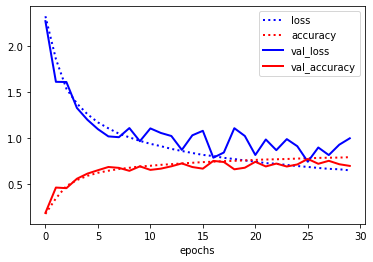

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 3,426,250
Trainable params: 3,426,250
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



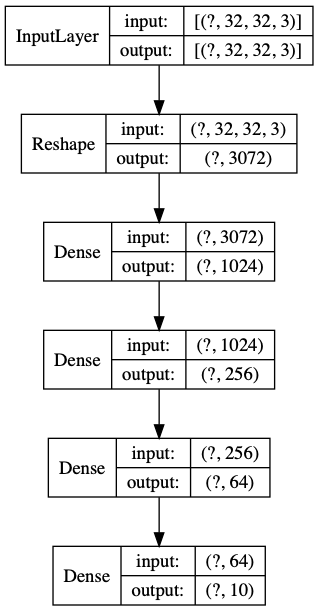

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Since I converted the images to greyscale, the input shape for the reshape layer changed to (32,32,1), and the parameter decreased to 1024. The dense layers remained the same. This model has a higher validation accuracy of 80.03%, which means that color is not helpful and even has a bad influence when recognizing the correct digit. Colors may make the digits less prominent, so the classification is more complicated. (length: 420)



Max val score: 80.03%


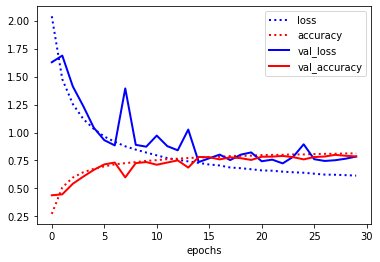

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_17 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 1,329,098
Trainable params: 1,329,098
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

At first, I added three BatchNormalization layers but the validation accuracy decreased to 78.66%. Then I removed the above layers and tried l2 regularization. Using this for the last hidden layer will slightly increase the accuracy to 80.85%, while for three or two hidden layers will decrease the accuracy. So I kept the l2 regularization for the last hidden layer. I also changed the batch_size to 32, and this attempt makes the performance better. (length: 452)



Max val score: 81.15%


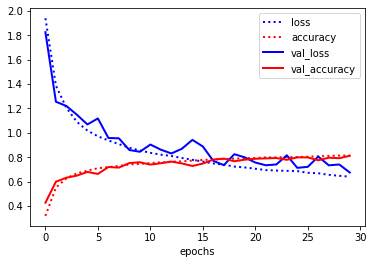

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I referred to the model used in the lab here and slightly changed its parameters. There are six convolutional layers. Every two convolutional layers I added a Maxpooling layer. After every Maxpooling, resolution halved in every dimension. To classify the images, a Dense and Softmax layer was added in the last. Furthermore, Dropout layers and Batchnormalization layers were added to regularize the model. This model worked very well. The accuracy of validation and training both are high and close to 1. However, it may be overfitting.  (length: 538)



Max val score: 95.46%


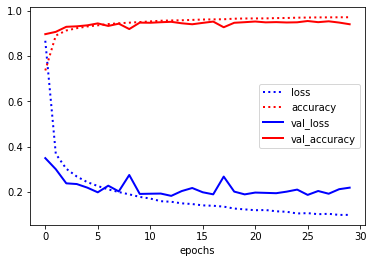

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    m

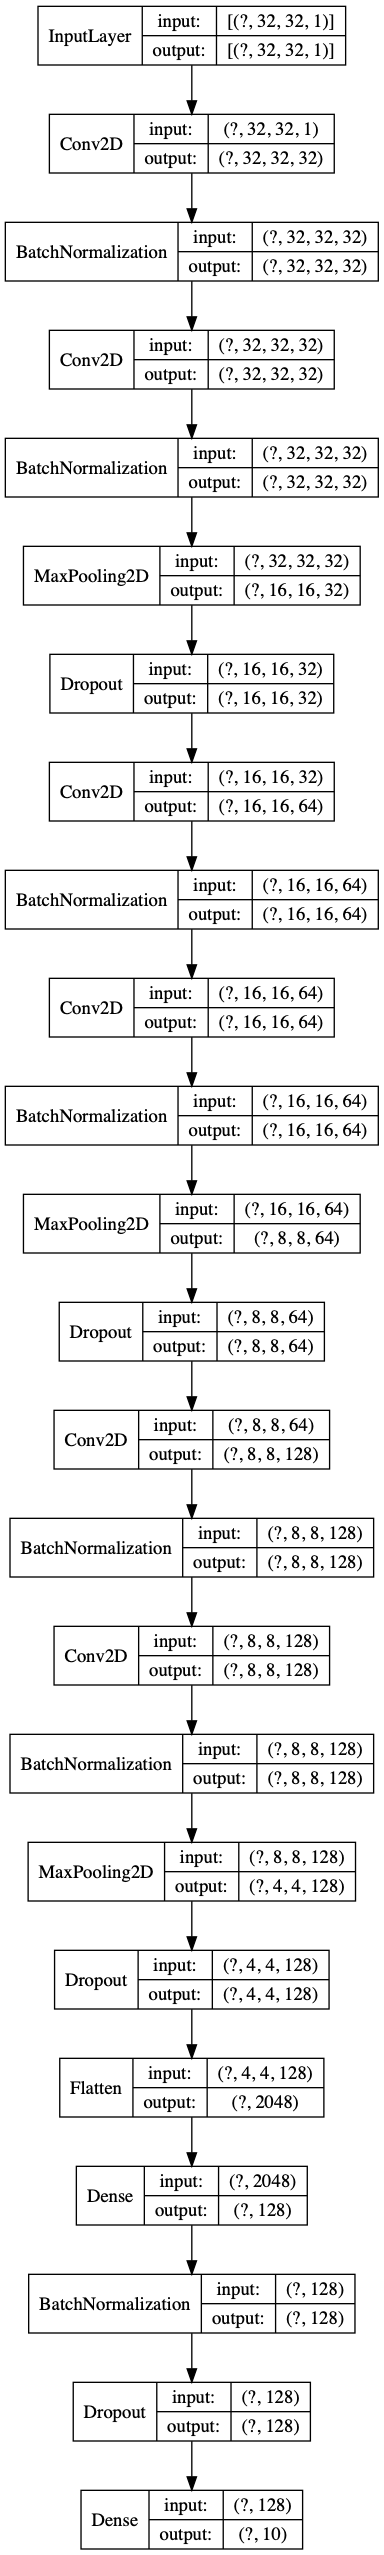

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

I used ImageDataGenerator here and adjusted its parameters to make the model better. However, after many attempts, I did not find the appropriate settings that can improve the validation accuracy. In the end, I used rotation_range, width_shift_range, height_shift_range, shear_range and fill_mode. The validation accuracy decreased by 5%, but the training accuracy decreased by 12%. This model seems to be less overfitting. (length: 424)



Max val score: 92.73%


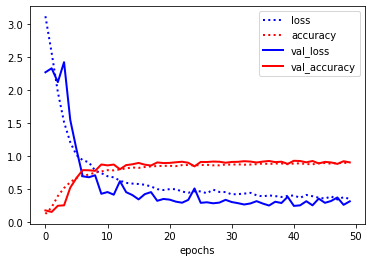


train_datagen = ImageDataGenerator(
      rotation_range=10,     # Rotate image up to 40 degrees
      width_shift_range=0.1, # Shift image left-right up to 20% of image width
      height_shift_range=0.1,# Shift image up-down up to 20% of image height
      shear_range=0.1,       # Shear (slant) the image up to 0.2 degrees 


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

The most common misclassification is between 1 and other labels. Most misclassifications involve 1, 3, 4, 7 and 10. I visualized the misclassification in class 1. I found that when writing 1 , people do not just draw a vertical line like |, but with a slanting horizontal line. So 1 will be easily misclassified as tilt 7 or 4. I also visualized in other classes. Some images have a very blurry background. Also, since 10 has two digits, it can easily be considered as another number. (length: 485)

Test score: 0.91%


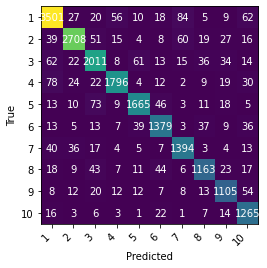

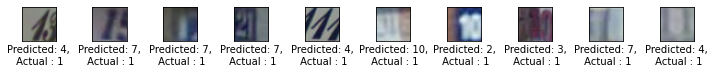

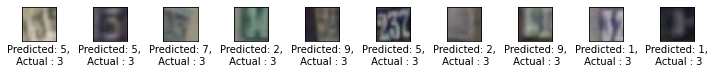

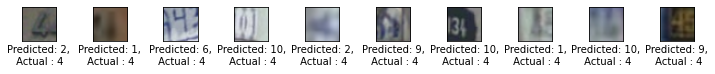

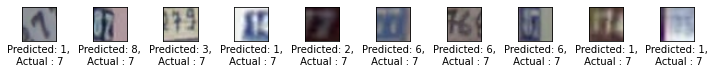

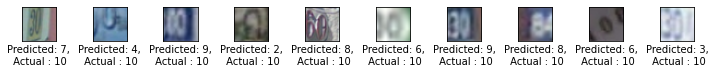

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

There are six figures for different convolutional layers. This model is useful. As can be seen from the figures, these convolutional layers indeed take the local characteristics of the digits. In the first figure, it focuses on relatively low-level features. Then, the latter convolution layer integrates the features of the previous convolution layer to form relatively complex features. So this can greatly reduce the impact of feature position on classification. (length: 466)



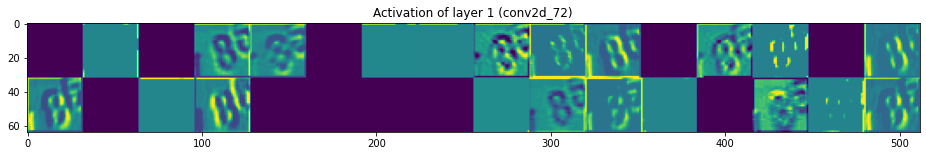

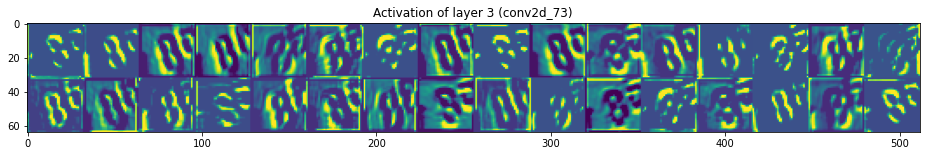

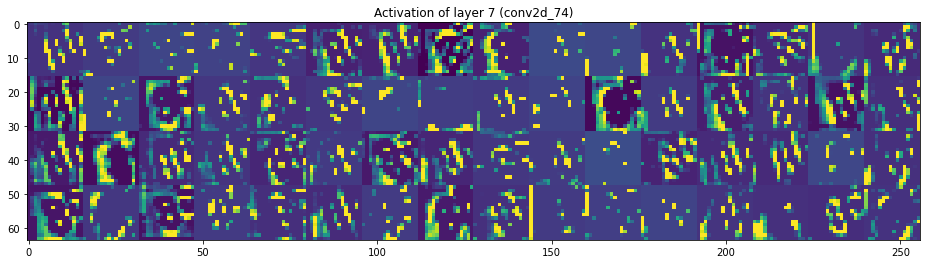

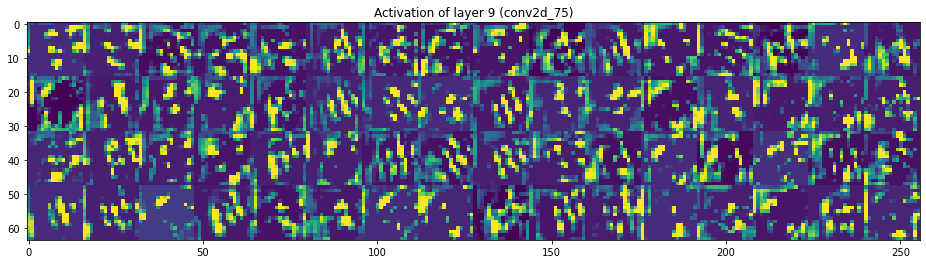

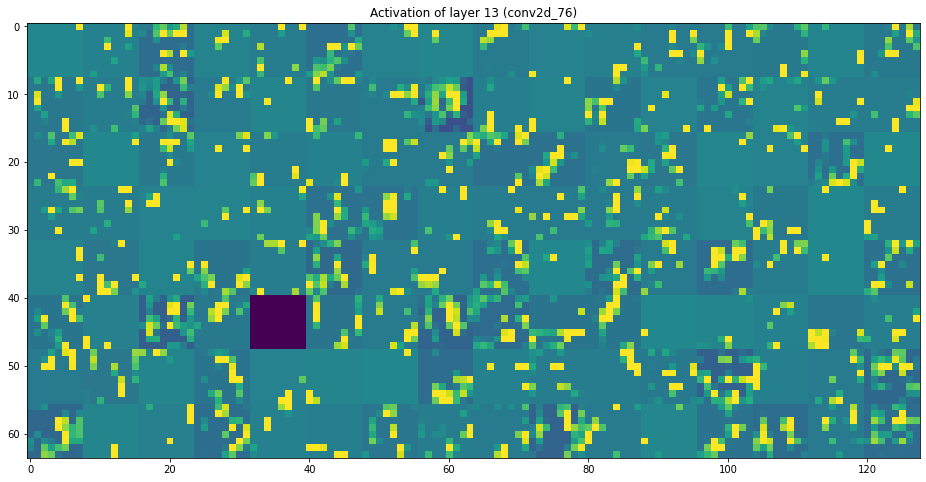

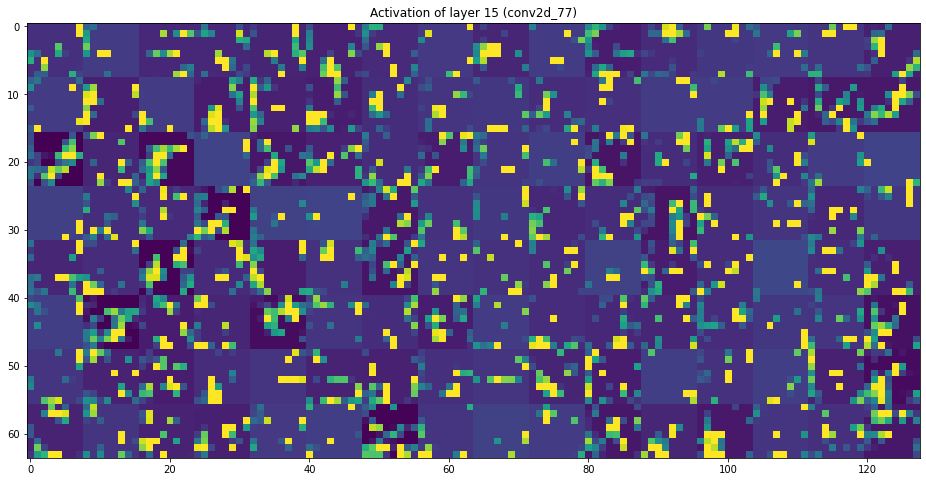

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

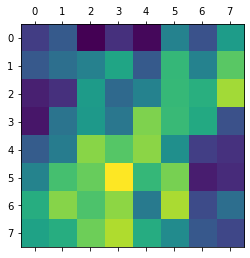

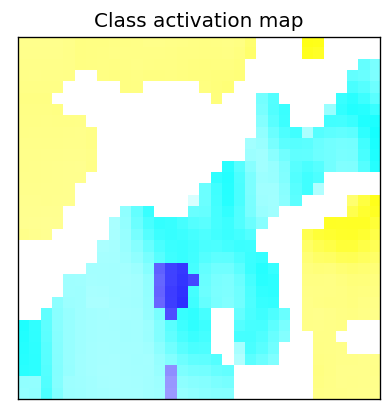

def plot_3_3():
    # tf.compat.v1.disable_eager_execution()
    # K.clear_session()
    x = rgb2gray(X_test)[0]
    x = np.expand_dims(x, axis=0)
    model_output = model.output[:]
    last_conv_layer = model.get_layer('conv2d_77')
    grads = K.gradients(model_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(64): #Why is there an warning when set to 128
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()

    img = X_test[0]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = he

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Freezing the convolutional base gets a validation accuracy of 61.40%. Unfreezing the convolutional layers of block5 gets a validation accuracy of 81.83%, which improves a lot. Unfreezing the convolutional layers of block5  and block4 gets a validation accuracy of 91.32% and this also increased a lot. (With above result, I set epochs=30 and batch_size=128. But the model is too large, so I rerun this cell.) (length: 409)



Max val score: 87.96%


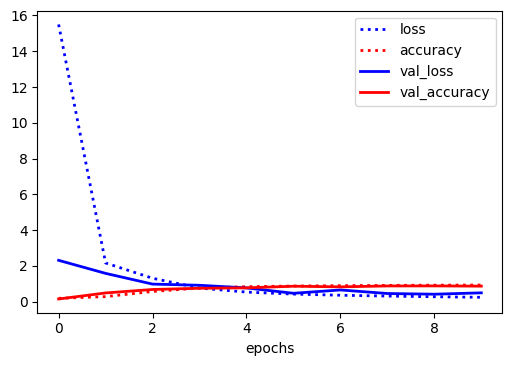

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_39 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 13,113,098
Non-trainable params: 1,735,488
_________________________________________________________________
None


def build_model_4_1():
    model = models.Sequential()
    model.add(conv_base)
    conv_layer = [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]
    for i in conv_layer[0:7]:    
        layer = model.layers[0].layers[i]
        layer.trainable = False
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    # conv_base.trainable = False
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



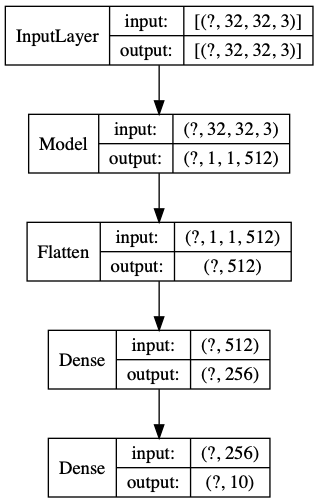

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Because I need to generate embeddings without the dense layers, I used 'get_layer' function. Then I embed the training and test data and store them. For generate_pipeline function, I chose RandomForestClassifier as a classifier for pipeline and set other parameters as default. For evaluate_pipeline function, I used the fit function and score function. For evaluation_4_2 function, I integrated the functions used earlier. The obtained accuracy score is 0.89309. Thus, this one is not my best model. (length: 501)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=1))])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model = load_model_from_file(base_dir, "model_4_1")
  conv_layers = model.get_layer('vgg16')
  store_embedding(conv_layers.predict(X_train_all).reshape(X_train_all.shape[0], 512), 'train')
  store_embedding(conv_layers.predict(X_test).reshape(X_test.shape[0], 512), 'test')

def evaluation_4_2(X_train, y_train, X_test, y_test):
  ""

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 105.01 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
